In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests    
from scipy import stats
%matplotlib inline



In [51]:
try:
    config_path=secretsPath
except:
    config_path='airquality-config.json'

print("loading configuration from "+config_path)    

loading configuration from airquality-config.json


In [52]:
    
try:
    with open(config_path) as f:                 
        data = json.load(f)
        webcom_database = data['webcom_database']
        webcom_key = data['webcom_key']
        location = data['location']
except:
    print("###")
    print("###")
    print("###")
    print('### to run the notebook locally, setup an airquality-config.json file from the example')
    print("###")
    print("###")
    print("###")

print("configuration loaded")    

configuration loaded


In [53]:
print("running with the following parameters")
print("webcom_database: "+webcom_database)    
print("location: "+location)    

running with the following parameters
webcom_database:airquality
location:juvisy


In [56]:

r = requests.get('https://io.datasync.orange.com/datasync/v2/'+webcom_database+'/data/'+location, 
                 headers={"content-type":"application/json", 
                          "Authorization": "Bearer "+webcom_key})
json_content = r.json()
#print(json.dumps(json_content, indent=2))
print ("size of the loaded json: " +str(len(json.dumps(json_content))/1024) +"K")



size of the loaded json: 27.7939453125K


In [34]:
data = []
for year in json_content:
    print(year)
    for month in json_content[year]:
        print(month)
        for day in json_content[year][month]:
            print(day)
            for measure in json_content[year][month][day]:
                print(measure)
                data.append( json_content[year][month][day][measure])
    
#print(json.dumps(data, indent=2))


size of the loaded json:20.099609375K
2020
04
22
-M5YtXDVUc0_qsDTHLDy
-M5Yt_ssL9fq5YBm0ITS
-M5YtdYF-dIlNszM9VLA
23
-M5_L4WmUil6OnJMorKv
-M5ad9ed8a-ZpqDCp0PL
-M5aHVSaiUlarprqqvAI
-M5aK0iqlIRXZZf1LXHV
-M5b6NaPYJ8vKanEyMbS
-M5bh8FtoaEtORyfTQs4
-M5_yMpHxUCQoCb6s6fY
-M5ZfHFRPQjx91z02__7
-M5Z9Z1cjPyf_L_ekJtS
-M5c2nTWpQEA0jjtU2_4
-M5bQWSslHCT2DSnR-hQ
-M5ZRA9sWLFGLbWxyv1S
-M5d-DwIBBvyQoUTkREe
-M5_eDK025VQtxMhd7MM
-M5cl73oNHt2Uy5_xSgU
-M5cndJw_X4bnl-BKuHN
-M5_IZXGSqs28NSALFUm
-M5cAM0C4IgHD9WVDLOH
-M5ZmpduJDtIMbcCll7w
-M5c5Jjht3fpbgI2Cpcv
-M5aMXrqOC5_VguIWa6O
-M5aiBxkoLzUwVIQ1BF1
-M5Z71q_2EZR1GL6zOXd
-M5_5ybdVYewlM-rkhS4
-M5b8tOcYf7q36b1WoQK
-M5apkTHgSGxD_SKAZS1
-M5ZH5lJau2TvvnxXQI0
-M5ZC4OH2t6SqNzoQGYK
-M5aki4n8vhakGWkV1sw
-M5ZWCZgi2cV0k75ahmf
-M5bjeP1b3ZPEovoupgK
-M5aZ7OFy5hFNW5BS9PF
-M5ZuNlxmPaPfgQBr1E6
-M5brCr0pIM38aBO2Tis
-M5_8UrT_lWQ5e-TLK5e
-M5cCshLCiRXJx6jQvj9
-M5c7psZRoc3PRlMAqUy
-M5cX0MX6fHHybXy-bIq
-M5bT1StvdHmoLHRSmi4
-M5auma08gcmSF12bIL0
-M5_0wA_pADBeYh1v2-X
-M5cPTKUwLPAImkeMuwo
-M5

In [3]:

#df = pd.read_json( json.dumps(json_content), orient='index', convert_dates=['ts'], date_unit='ms')
df = pd.read_json( json.dumps(data),  convert_dates=['ts'], date_unit='ms')
df = df.set_index('ts')
df.tail()

,pm_10_0,pm_1_0,pm_2_5
ts,,,
2020-04-25 06:07:12.842,9,6,9
2020-04-24 23:42:12.672,11,8,10
2020-04-25 05:56:13.343,9,5,8
2020-04-25 02:16:12.716,12,7,11
2020-04-25 04:50:13.275,10,6,9


In [4]:
df.pm_2_5.mean()

15.235668789808917

In [5]:
stats.gmean(df.pm_2_5)

14.3695208619053

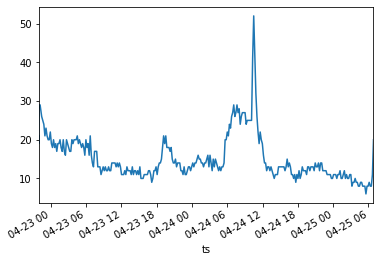

In [6]:
#df.groupby([df.ts.dt.strftime('%y%m%d %H:%M')])
df.pm_2_5.plot(kind='line')

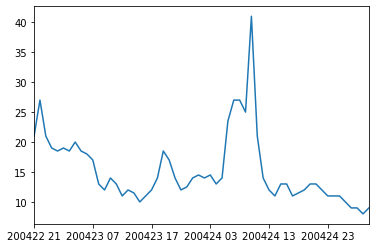

In [7]:
df.groupby([df.index.strftime('%y%m%d %H')]).pm_2_5.median().plot()

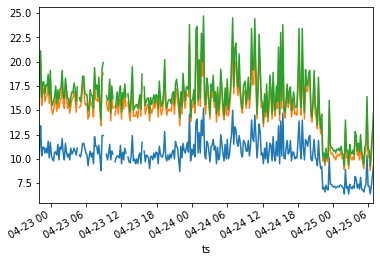

In [8]:
df.pm_1_0.rolling(10).mean().plot()
df.pm_2_5.rolling(10).mean().plot()
df.pm_10_0.rolling(10).mean().plot()


In [9]:
import altair as alt 

alt.Chart(df.reset_index()).mark_line().encode(
    x='ts:T',
    y='pm_1_0:Q',    
).interactive()

alt.Chart(...)

In [10]:
long_form=df.reset_index().melt('ts', var_name='particle', value_name='value')

alt.Chart(long_form).mark_line().encode(
  x='ts:T',
  y='value:Q',
  color='particle:N'
).interactive()


alt.Chart(...)

In [11]:
long_form=df.reset_index().melt('ts', var_name='particle', value_name='value')


click = alt.selection_multi(encodings=['color'])


line = alt.Chart(long_form).mark_line().encode(
  x='ts:T',
  y='value:Q',
  color='particle:N',
  size=alt.value(3),
).transform_window(
    rolling_mean='mean(value)',
    frame=[-10, 0]
).encode(
    x='ts:T',
    y='rolling_mean:Q'
).transform_filter(
    click
).interactive()

points = alt.Chart(long_form).mark_point().encode(
    x='ts:T',
    y=alt.Y('value:Q',
            axis=alt.Axis(title='particle count')),
    color='particle:N',
    size=alt.value(1),
    tooltip=['monthdate(ts):T','hoursminutes(ts):T','particle:N','value:Q'],
).transform_filter(
    click
).interactive()

legend = alt.Chart(long_form).mark_rect().encode(
    y=alt.Y('particle:N', axis=alt.Axis(title='Particle type')),
    color=alt.condition(click, 'particle:N', 
                        alt.value('lightgray'), legend=None),
    size=alt.value(250)
).properties(
    selection=click
)

chart = (points + line) | legend

chart.save('cars-clickable-legend.html')

chart

alt.HConcatChart(...)